C:\Users\TR\AppData\Local\Temp\ipykernel_20164\3868605405.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgb = ls.shade(data_small, cmap=cm.get_cmap(cmap), blend_mode='soft',


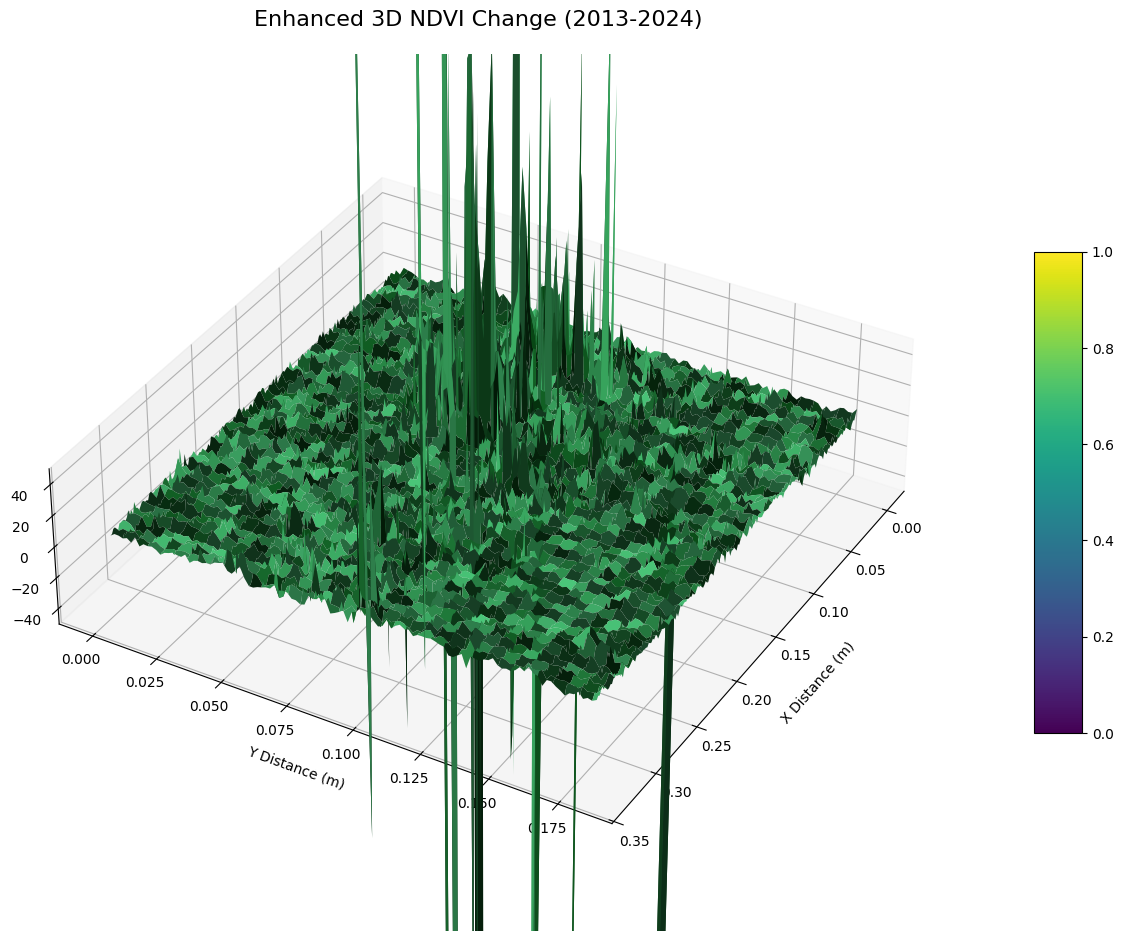

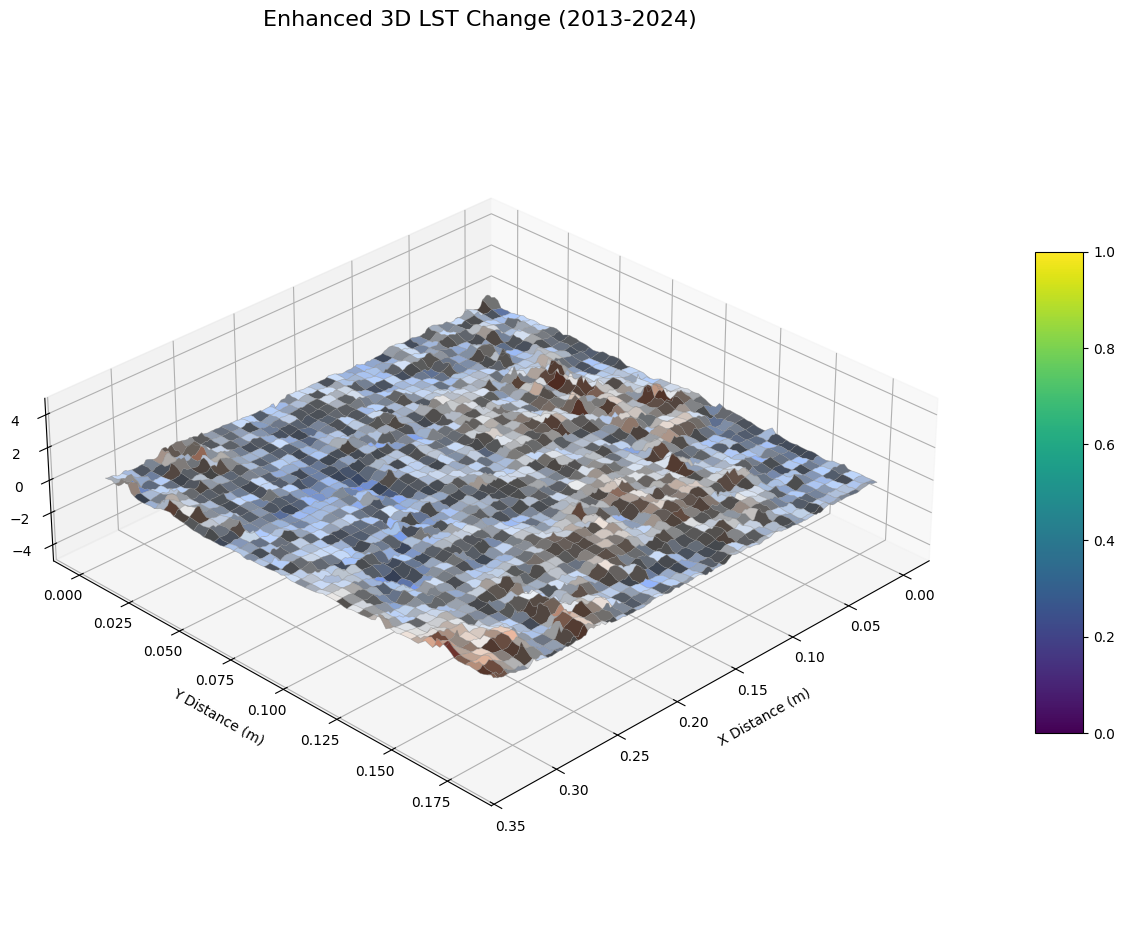

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterio
import plotly.graph_objects as go
from matplotlib import cm
from matplotlib.colors import LightSource

def improved_plot_3d_surface(raster_path, title='3D Surface Plot', cmap='viridis', zlim=None, 
                            subsample=4, figsize=(12, 10), elev=30, azim=45, 
                            lighting=True, shade=True, edge_color=None, alpha=1.0):
    """
    Create an improved 3D surface plot with better scaling and options
    
    Parameters:
    -----------
    raster_path : str
        Path to the raster file
    title : str
        Plot title
    cmap : str
        Matplotlib colormap name
    zlim : tuple or None
        Optional z-limits as (min, max)
    subsample : int
        Subsampling factor to reduce data size (higher = smaller plot, faster rendering)
    figsize : tuple
        Figure size as (width, height)
    elev : float
        Elevation viewing angle in degrees
    azim : float
        Azimuth viewing angle in degrees
    lighting : bool
        Whether to add 3D lighting effects
    shade : bool
        Whether to add shading effects
    edge_color : str or None
        Color for edges or None for no edges
    alpha : float
        Transparency (0.0 to 1.0)
    """
    # Open and read raster
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        data = np.nan_to_num(data, nan=0.0)
        transform = src.transform
        
        # Get spatial reference info
        xres = transform[0]
        yres = transform[4]
        
    # Apply subsampling to make plot more manageable
    data_small = data[::subsample, ::subsample]
    rows, cols = data_small.shape
    
    # Create coordinate arrays in real-world units if available
    x = np.arange(0, cols) * xres * subsample
    y = np.arange(0, rows) * abs(yres) * subsample
    X, Y = np.meshgrid(x, y)
    
    # Create figure and 3D axis
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Calculate appropriate scaling factor to make z-axis proportional to x,y
    if zlim:
        zrange = zlim[1] - zlim[0]
    else:
        zrange = data_small.max() - data_small.min()
    
    # Calculate median width of the x and y dimensions
    xy_range = (x.max() + y.max()) / 2
    
    # Make z axis about 1/3 of the xy range for good proportions
    scale_z = xy_range / (zrange * 3)
    
    # Apply light source for better 3D appearance
    if lighting:
        ls = LightSource(azdeg=315, altdeg=45)
        rgb = ls.shade(data_small, cmap=cm.get_cmap(cmap), blend_mode='soft', 
                      vert_exag=2, norm=plt.Normalize(data_small.min(), data_small.max()))
        surf = ax.plot_surface(X, Y, data_small, facecolors=rgb, linewidth=0, 
                              antialiased=True, shade=shade, alpha=alpha)
    else:
        surf = ax.plot_surface(X, Y, data_small, cmap=cmap, linewidth=0, 
                              antialiased=True, shade=shade, alpha=alpha)
    
    # Add edges if requested
    if edge_color:
        ax.plot_wireframe(X, Y, data_small, color=edge_color, linewidth=0.5, alpha=0.5)
    
    # Adjust the scaling of the z-axis
    ax.set_box_aspect([1, 1, 0.3])  # Adjust z scaling relative to x and y
    
    # Set labels and title
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('X Distance (m)', labelpad=10)
    ax.set_ylabel('Y Distance (m)', labelpad=10)
    ax.set_zlabel('Value', labelpad=10)
    
    # Set the viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Set z limits if provided
    if zlim:
        ax.set_zlim(zlim)
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
    
    plt.tight_layout()
    return fig

def interactive_3d_plot(raster_path, title='Interactive 3D Plot', colorscale='Viridis', 
                        zmin=None, zmax=None, subsample=4, width=900, height=700):
    """
    Create an interactive 3D plot using Plotly
    
    Parameters:
    -----------
    raster_path : str
        Path to the raster file
    title : str
        Plot title
    colorscale : str
        Plotly colorscale name
    zmin, zmax : float or None
        Value limits for colorscale
    subsample : int 
        Subsampling factor to reduce data size
    width, height : int
        Figure dimensions in pixels
    """
    # Open and read raster
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        data = np.nan_to_num(data, nan=0.0)
        transform = src.transform
    
    # Subsample data for better performance
    data_small = data[::subsample, ::subsample]
    
    # Create the figure
    fig = go.Figure(data=[go.Surface(
        z=data_small,
        colorscale=colorscale,
        cmin=zmin,
        cmax=zmax,
        contours={
            "z": {"show": True, "start": zmin, "end": zmax, "size": (zmax-zmin)/10 if zmin is not None and zmax is not None else None}
        }
    )])
    
    # Update layout
    fig.update_layout(
        title={"text": title, "y": 0.9, "x": 0.5, "xanchor": "center", "yanchor": "top", "font": {"size": 24}},
        scene={
            "aspectratio": {"x": 1, "y": 1, "z": 0.4},
            "camera": {"eye": {"x": 1.5, "y": 1.5, "z": 0.8}},
            "xaxis": {"title": "X Distance", "nticks": 10},
            "yaxis": {"title": "Y Distance", "nticks": 10},
            "zaxis": {"title": "Value", "nticks": 10}
        },
        width=width,
        height=height,
        margin={"l": 65, "r": 50, "b": 65, "t": 90},
        scene_camera_eye={"x": 1.5, "y": 1.5, "z": 0.8}
    )
    
    return fig

# Example usage
if __name__ == "__main__":
    # Replace with your actual paths
    ndvi_path = "./change-detection-cumulative/NDVI_CumulativeChange_2013_2024.tif"
    lst_path = "./change-detection-cumulative/LST_CumulativeChange_2013_2024.tif"
    
    # Create static 3D plots with improved scaling
    fig_ndvi = improved_plot_3d_surface(
        ndvi_path, 
        title="Enhanced 3D NDVI Change (2013-2024)", 
        cmap='YlGn', 
        zlim=(-50, 50),
        subsample=6,  # Increase for faster rendering, decrease for more detail
        elev=35,      # Viewing elevation angle
        azim=30       # Viewing azimuth angle
    )
    plt.show()
    
    fig_lst = improved_plot_3d_surface(
        lst_path, 
        title="Enhanced 3D LST Change (2013-2024)", 
        cmap='coolwarm', 
        zlim=(-5, 5),  # Narrower range for better contrast
        subsample=6,
        lighting=True,
        shade=True,
        edge_color='gray'
    )
    plt.show()
    
    # Create interactive plots
    fig_ndvi_interactive = interactive_3d_plot(
        ndvi_path,
        title="🌱 Interactive 3D NDVI Change", 
        colorscale='Greens', 
        zmin=-40, 
        zmax=40,
        subsample=8  # Higher for smoother interactive experience
    )
    fig_ndvi_interactive.show()
    
    fig_lst_interactive = interactive_3d_plot(
        lst_path,
        title="🔥 Interactive 3D LST Change", 
        colorscale='RdBu_r', 
        zmin=-5, 
        zmax=5,
        subsample=8
    )
    fig_lst_interactive.show() 